<a href="https://colab.research.google.com/github/acse-srm3018/DeeplearningProxy/blob/main/Notebooks/Reconstructin_pressure_Stanford_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jul 21 18:14:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
import numpy as np
import h5py
import unet_uae as vae_util
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
sess = tf.compat.v1.Session(config=config)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
input_shape=(80,80,2)
depth = 10
vae_model,_ = vae_util.create_vae(input_shape, depth)
#vae_model.summary()

output shape is  (None, 10, 80, 80, 1)


In [7]:
def load_data(data_path, array_name_list):
    hf_r = h5py.File(data_path, 'r')
    result = []
    for name in array_name_list:
        result.append(np.array(hf_r.get(name)))
    hf_r.close()
    return result

In [8]:
data_path = '/content/drive/MyDrive/channel_80x80_25w_lhs2967_bhp3_2000d_runs_3 (1).h5'
# load training data
#data_path = os.path.join(data_dir, 'channel_80x80_25w_lhs2967_bhp3_2000d_runs_3.h5')
p_t, logk = load_data(data_path, ['pressure', 'logk'])
# load eval data
print('p_t shape is ', p_t.shape)
print('logk shape is ', logk.shape)

p_t shape is  (2967, 41, 80, 80)
logk shape is  (2967, 1, 80, 80)


In [9]:
depth = 10
nr = logk.shape[0]
train_nr = 1500
test_nr = 50

In [10]:
p_t_mean = np.mean(p_t[:train_nr, ...], axis = 0, keepdims = True)
p_t = p_t - p_t_mean
print('max p is ', np.max(p_t[:train_nr, ...]), ', min p is ', np.min(p_t[:train_nr, ...]))
max_p = np.max(p_t[:train_nr, ...])
min_p = np.min(p_t[:train_nr, ...])

max p is  84.27208540634274 , min p is  -90.98400769142245


In [11]:
p_t = (p_t - min_p)/(max_p -min_p) - 0.5
print('max p is ', np.max(p_t), ', min p is ', np.min(p_t))
print('max p train is ', np.max(p_t[:train_nr, ...]), ', min p train is ', np.min(p_t[:train_nr, ...]))

max p is  0.5 , min p is  -0.5081386220006174
max p train is  0.5 , min p train is  -0.5


In [12]:
step_index = [1, 2, 4, 6, 8, 10, 12, 14, 17, 20]

train_x = np.concatenate([logk[:train_nr, ...],p_t[:train_nr,[0], ...]], axis = 1)
train_y = p_t[:train_nr,step_index,...]

test_x = np.concatenate([logk[nr-test_nr:, ...],  p_t[nr-test_nr:, [0], ...]], axis = 1)
test_y = p_t[nr-test_nr:,step_index,...]


train_x = train_x.transpose(0,2,3,1)
train_y = train_y[:,:,:,:,None]
test_x = test_x.transpose(0,2,3,1)
test_y = test_y[:,:,:,:,None]
#test_y = test_y.transpose(0,2,3,1)
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)


train_x shape is  (1500, 80, 80, 2)
train_y shape is  (1500, 10, 80, 80, 1)
test_x shape is  (50, 80, 80, 2)
test_y shape is  (50, 10, 80, 80, 1)


<Figure size 432x288 with 0 Axes>

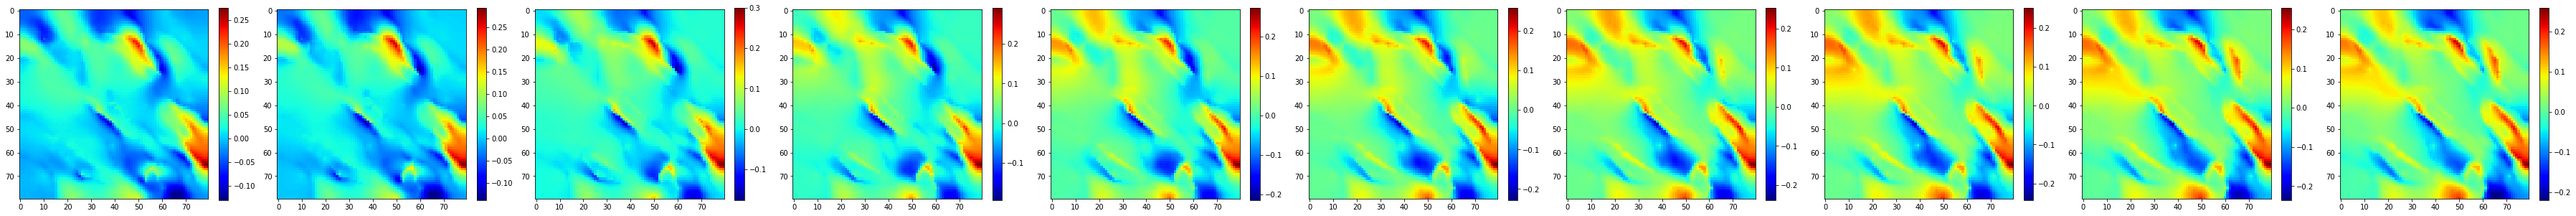

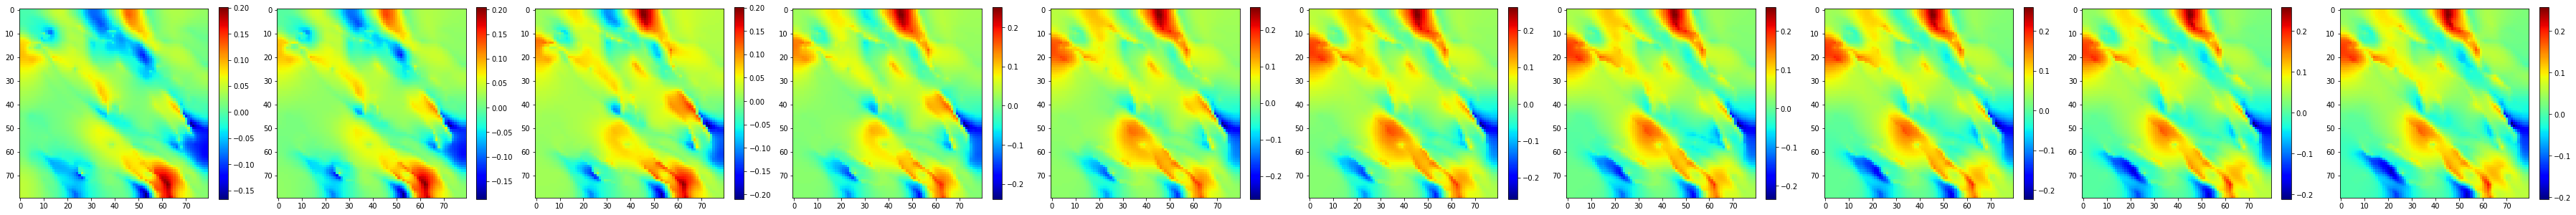

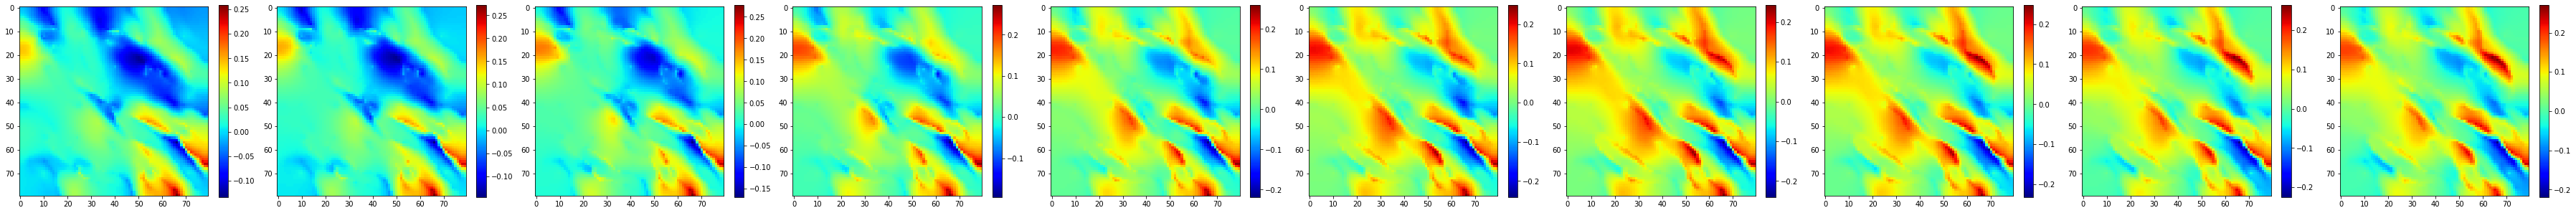

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')
ind_case = [0, 10, 20]

for k in range(len(ind_case)):
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(1, depth, i_tstep+1)
        plt.imshow(train_y[k, i_tstep, :, :, 0])
        plt.colorbar(fraction=0.046)
        plt.tight_layout()
plt.show()

In [14]:
output_dir = 'saved_models/'

In [15]:
epochs = 500
train_nr = train_x.shape[0]
test_nr = 10
batch_size = 16
num_batch = int(train_nr/batch_size) 

In [16]:
def vae_loss(x, t_decoded):
    '''Total loss for the plain UAE'''
    return K.mean(reconstruction_loss(x, t_decoded))



def reconstruction_loss(x, t_decoded): # abs loss
    '''Reconstruction loss for the plain UAE'''

    return K.sum(K.abs(K.batch_flatten(x) - K.batch_flatten(t_decoded)) , axis=-1)


def relative_error(x, t_decoded):
    return K.mean(K.abs(x - t_decoded) / x)

In [17]:
opt = Adam(learning_rate=3e-4)
vae_model.compile(loss = vae_loss, optimizer = opt, metrics = [relative_error])

In [18]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lrScheduler = ReduceLROnPlateau(monitor = 'loss', factor = 0.5, patience = 10, cooldown = 1, verbose = 1, min_lr = 1e-6)
filePath = 'saved_models/saved-model-pressure-mae-{epoch:03d}-{val_loss:.2f}.h5'
checkPoint = ModelCheckpoint(filePath, monitor = 'val_loss', verbose = 1, save_best_only = False, \
                             save_weights_only = True, mode = 'auto')

callbacks_list = [lrScheduler, checkPoint]

In [19]:
history = vae_model.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, \
                        verbose = 1, validation_data = (test_x, test_y))

Epoch 1/500
94/94 [==============================] - 68s 237ms/step - loss: 13687.3762 - relative_error: -0.9103 - val_loss: 5128.8999 - val_relative_error: -0.2688
Epoch 2/500
94/94 [==============================] - 18s 195ms/step - loss: 3540.0987 - relative_error: 1.4584 - val_loss: 5681.8237 - val_relative_error: -0.4226
Epoch 3/500
94/94 [==============================] - 18s 197ms/step - loss: 3242.7712 - relative_error: 1.1109 - val_loss: 4465.7173 - val_relative_error: -0.2481
Epoch 4/500
94/94 [==============================] - 18s 197ms/step - loss: 3176.6792 - relative_error: 0.7537 - val_loss: 3775.3022 - val_relative_error: -0.1067
Epoch 5/500
94/94 [==============================] - 18s 196ms/step - loss: 3109.9893 - relative_error: 3.2171 - val_loss: 3206.3145 - val_relative_error: 0.0165
Epoch 6/500
94/94 [==============================] - 18s 197ms/step - loss: 2874.3143 - relative_error: 1.4133 - val_loss: 3007.1707 - val_relative_error: -0.0048
Epoch 7/500
94/94 [==